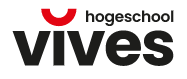<br>


**INTRODUCTION TO ARTIFICIAL INTELLIGENCE**<br>
Academiejaar 2024-2025<br>
Stefaan Haspeslagh<br>
Andy Louwyck<br>

---



---



# Maze: NDS en IDS

## Inleiding

Het doolhofprobleem is een veel gebruikt probleem om zoekalgoritmen op uit te testen. Een doolhof is een rooster met n x n vakken. Een vak kan een barrière bevatten, dit zijn vakjes waarop niet kan 'gewandeld' worden.
De uitdaging is om, gegeven een startpositie (links onder in het voorbeeld), een pad naar het doel te vinden (rechts boven in het voorbeeld).
Mogelijke richtingen waarin gewandeld kan worden (in die volgorde!) zijn: links, rechts, naar boven en naar onder. Diagonaal kan er niet gewandeld worden.

In deze notebook herwerken we de state-space representation van het doolhofprobleem die we in de vorige topics hebben uitgewerkt en implementeren we ***non deterministic search*** en ***iterative deepening***. 

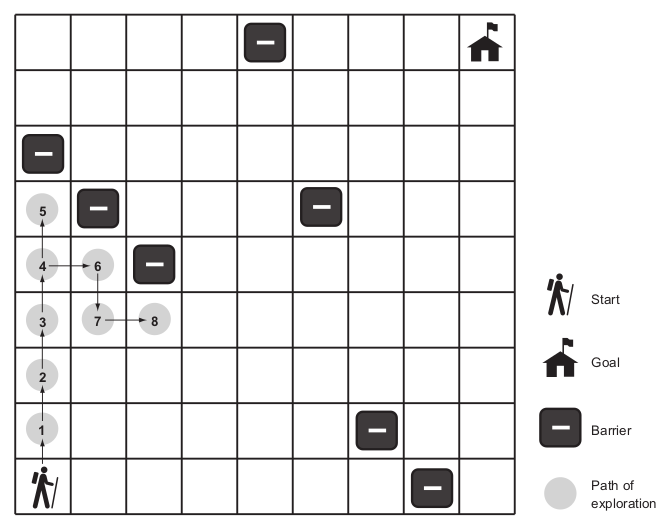

## State-Space Representation - Revisited

### OO-model

We implementeren een generiek OO-model waarin de volgende concepten van de state-space representation een plaats krijgen:

**state**

Houdt specifieke informatie omtrent de toestand van een zoekprobleem bij. We modelleren dit als een abstracte klasse `State`. Objecten van dit type stellen dan verschillende toestanden van het probleem voor. Voor elk nieuw zoekprobleem zal je een nieuwe klasse moeten ontwerpen die overerft van deze abstracte klasse. Op een state worden de production rules toegepast waaruit dan één move wordt geselecteerd die wordt toegepast op de state om in een nieuwe state te komen.

**goal**

Van elke toestand moeten we kunnen evalueren of dit de doeltoestand van het probleem is. We voorzien hiervoor een functie `is_goal()` in de generieke klasse `State`.

**production rule**

De production rules beschrijven welke 'acties' er kunnen uitgevoerd worden vanuit een state. De production rules formuleren dit eenduidig onafhankelijk van de state. Bijvoorbeeld: vanuit een willekeurig vakje zijn de mogelijke acties een stap naar links, naar rechts, naar boven of naar onder. We maken voor dit concept een klasse `ProductionRule` aan. Concrete rules voor een specifiek probleem moeten hiervan overerven. Het toepassen van een *rule* op een *state* wordt voorgesteld door de functie `apply(self, state) -> Move` en resulteert in een `Move`.

**move**

Een move is zoals hierboven aangehaald een concrete verandering van een welgedefinieerde toestand naar een nieuwe toestand. Dit concept wordt voorgesteld door een klasse `Move`. Een move is één van de production rules die wordt toegepast op een gegeven state. Klasse `Move` krijgt daarom bij instantiatie een welbepaald `State` object en een `ProductionRule` object mee. Een move kan soms niet geldig zijn; dit wordt gecheckt met de methode `is_valid`. Denk aan het doolhofprobleem: als je bijv. in de linkerkolom staat, dan kan je niet naar links bewegen. Met de functie `apply()` pas je de `rule` toe op de `state` en krijg je de nieuwe toestand, een nieuw `State` object dus. Zoals je gezien hebt in de theorie kan er een kost verbonden zijn aan het veranderen van de toestand. Die `cost` modelleren we nu al. Bij *blind search* is deze kost nog niet relevant, in verdere topics zal die wel gebruikt worden.

**path**

Een pad, gemodelleerd met de klasse `Path`, is een opeenvolging van toestanden, die begint bij de initiële toestand, en hopelijk eindigt in de doeltoestand (goal). Daarom moet je op een pad de functie `reaches_goal()` kunnen oproepen die controleert of een pad eindigt in de goal. Paden moeten ook kunnen gecontroleerd worden op *loops* met de methode `has_loop()`. Vanuit een bepaald pad moet je alle kinderen kunnen oproepen. De kinderen van een pad bekom je door het pad uit te breiden met alle mogelijke afstammelingen van de laatste toestand op het pad. Dit is geïmplementeerd in de methode `calculate_children()`. Let op: bij het berekenen van de kinderen zijn loops toegelaten! Verder heeft elke pad een lengte (property `length`): dit is het aantal toestanden (knopen) op het pad. De methode `add(self, state)` is een hulpmethode om een pad uit te breiden naar een nieuwe toestand en dus een nieuw pad te maken.

De OO-structuur biedt een generiek kader waarin we verschillende zoekproblemen kunnen formuleren. In commentaar wordt meer info gegeven over de ontwerpbeslissingen in dit model.

In [ ]:
# eerst importeren we de nodige Python packages, modules, klassen en functies
from abc import ABC, abstractmethod

In [ ]:
# superklasse Move
class Move:
    
    def __init__(self, state, rule, cost=1):
        # state is een State object
        # rule is een ProductionRule object
        self.state = state
        self.rule = rule
        self.cost = cost
    
    def is_valid(self):
        # Checkt of de Move self geldig is.
        # Retourneert True of False.
        return self.state.is_valid_move(self)
    
    def apply(self):
        # Past Move self toe op toestand state en geeft een nieuw State object terug
        return self.state.apply_move(self)

In [ ]:
# superklasse ProductionRule
class ProductionRule:
    
    def apply(self, state) -> Move:
        # methode die een Move object teruggeeft om ProductionRule self op self.state toe te kunnen passen
        return Move(state, self)

In [ ]:
# abstracte superklasse State
class State(ABC):

    rules = []  # list met ProductionRule objecten
    
    def apply_production_rules(self):
        # Op een state wordt deze methode aangeroepen met de production rules om
        # de moves te berekenen die het probleem in een nieuwe toestand kunnen brengen.
        # Deze functie geeft dus een lijst van moves terug.
        return [rule.apply(self) for rule in self.rules]

    @abstractmethod
    def is_valid_move(self, move):
        # Het toepassen van een move op een state kan leiden tot een ongeldige toestand.
        # Deze functie controleert of een state al dan niet een geldige toestand van het probleem is.
        # Retourneert dus een boolean.
        pass
    
    @abstractmethod
    def apply_move(self, move):
        # Op een state kan een move toegepast worden om naar een volgende state over te gaan.
        # Deze functie geeft dus een nieuwe state terug.
        pass
    
    @abstractmethod
    def is_goal(self):
        # Controleert of een state de `goal state` is.
        # Retourneert dus een booleaanse waarde.
        pass
    
    @abstractmethod
    def __eq__(self, other):
        # Vergelijkt toestand self met een andere toestand other
        # nodig om te checken of er al dan niet loops zijn in een pad
        pass

In [ ]:
# superklasse Path
class Path:

    def __init__(self, *states):
        self.states = states # een path is een opeenvolging van toestanden
    
    @property
    def length(self):
        # Geeft de lengte van het pad terug, dit is het aantal knopen op het pad,
        # dus het aantal toestanden dat bereikt worden op het pad
        return len(self.states)

    def has_loop(self):
        # Een pad bevat een 'loop' indien er twee toestanden op het pad gelijk zijn aan elkaar
        # aangezien de zoekalgoritmen telkens 'loops' verwijderen uit de queue
        # kan er enkel een loop ontstaan indien het pad uitgebreid wordt,
        # dus volstaat het enkel de laatst toegevoegde toestand op het pad te vergelijken met de voorgaande.
        return any([self.states[-1] == other for other in self.states[:-1]])

    def reaches_goal(self):
        # Controleert of het pad naar de goaltoestand leidt.
        # Roept dus de methode is_goal() op de laatste toestand op het pad op.
        return self.states[-1].is_goal()

    def calculate_children(self):
        # Activeert de "production rules" op de laatste state, om nieuwe afstammelingen (descendants)
        # te genereren. De paden naar die nieuwe descendants zijn de kinderen van het huidige pad (self).
        # Let op! Die paden kunnen loops bevatten!
        moves = self.states[-1].apply_production_rules()
        return [self.add(move.apply()) for move in moves if move.is_valid()]
    
    def add(self, state):
        # Voegt een toestand toe aan het huidige pad.
        # Geeft dus een nieuw pad terug, dat leidt tot de opgegeven toestand.
        return Path(*self.states, state)

    def __repr__(self):
        # Een pad is een opeenvolging van states.
        # De generieke string-voorstelling van een pad is dus de string-voorstelling van die states.
        states = ", ".join([str(state) for state in self.states])
        return f"[{states}]"

### Implementatie voor doolhof

We kunnen nu ons specifieke doolhofprobleem implementeren door specifieke subklassen te definiëren die erven van de superklassen uit het generieke OO-model dat we hierboven hebben geïmplementeerd.

Aan de hand van de *positie* (`Position`), wat het vakje is waar we staan, en de *configuratie* van het doolhof (`Maze`) definiëren we een specifiek **move** in het doolhof m.b.v. klasse `MazeMove` die erft van `Move`. 

Om vanuit een *state* verschillende *moves* te genereren implementeren we de **production rules** m.b.v. klassen die erven van `ProductionRule`:
- `Left`
- `Right`
- `Up`
- `Down`

De uiteindelijke klasse `MazeState` implementeert dan de **state** m.b.v. alle voorgaande klasses. De **state** wordt gedefinieerd a.d.h.v. een positie in het doolhof, vandaar dat klasse `MazeState` attributen `position` en `maze` bevat. Klasse `MazeState` erft van `State` en moet alle abstracte methoden implementeren. 

In [ ]:
# eerst importeren we de nodige Python packages, modules, klassen en functies
from IPython.display import clear_output
from time import sleep
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

In [ ]:
# klasse Position
class Position:
  
    def __init__(self, irow, icol):
        # Een positie definiëren we adhv rij index irow en kolom index icol van het vakje
        self.irow = irow
        self.icol = icol

    def __eq__(self, other):
        # Twee posities zijn hetzelfde als hun rij en kolom indices gelijk zijn
        return self.irow == other.irow and self.icol == other.icol
    
    def __repr__(self):
        # String voorstelling van de positie: (irow, icol)
        return "({}, {})".format(self.irow, self.icol)

In [ ]:
# klasse Maze met de doolhofconfiguratie
class Maze:
   
    symbols = ('*', '.', '#', 'o')  # start = *, free = ., wall = #, goal = o 
    
    def __init__(self, grid):
        # grid is een integer array:
        # start = 0, free = 1, wall = 2, goal = 3
        self.grid = np.array(grid)
        self.size = self.grid.shape[0]  # aantal rijen = aantal kolommen van het doolhof rooster

    def get_start_position(self):
        # Retourneert startpositie (= Position object)
        irow, icol = np.where(self.grid == 0)
        return Position(irow[0], icol[0])

    def get_goal_position(self):
        # Retourneert eindpositie (= Position object)
        irow, icol = np.where(self.grid == 3)
        return Position(irow[0], icol[0])
    
    def is_valid_position(self, position):
        # Checkt of een positie geldig is: moet binnen het grid liggen en mag geen barrière zijn
        return (0 <= position.irow < self.size and
                0 <= position.icol < self.size and 
                self.grid[position.irow, position.icol] != 2)
    
    def plot(self):
        # Plot het doolhof
        cmap = colors.ListedColormap(['forestgreen', 'lightyellow', 'purple', 'red'])  # colormap
        bounds = np.linspace(-0.5, 3.5, 5)
        norm = colors.BoundaryNorm(bounds, cmap.N)
        # plot grid
        plt.matshow(self.grid, cmap=cmap, norm=norm)
        # axes
        xmax = self.size - 0.5
        ymax = self.size - 0.5
        ax = plt.gca()
        ax.set_aspect("equal")
        ax.set_xticks(np.linspace(-0.5, xmax, self.size + 1))
        ax.set_xticklabels([])
        ax.set_yticks(np.linspace(-0.5, ymax, self.size + 1))
        ax.set_yticklabels([])
        ax.tick_params(axis=u'both', which=u'both', length=0)
        # plot grid and set axis limits
        plt.grid()
        plt.xlim([-0.5, xmax])
        plt.ylim([ymax, -0.5])
        
    def __repr__(self):
        # String representatie van het doolhof
        return "\n".join([''.join([self.symbols[item] for item in row]) for row in self.grid])

    @staticmethod
    def create(maze):
        # Creëert grid adhv list van list met strings "maze"
        # Retourneert een Maze object
        return Maze(grid=[[Maze.symbols.index(symbol) for symbol in row] for row in maze])

In [ ]:
# klasse MazeProductionRule die erft van klasse ProductionRule
class MazeProductionRule(ProductionRule):

    def __init__(self, drow=0, dcol=0):
        # Een production rule in dit geval is één vakje naar links, rechts, boven of onder opschuiven
        # De nieuwe positie heeft coördinaat (irow+drow, icol+dcol)
        super().__init__()
        self.drow = drow
        self.dcol = dcol

    def __repr__(self):
        # We stellen de production rule voor als 'left', 'right', 'up' of 'down'.
        if self.dcol == -1:
            return 'left'
        if self.dcol == 1:
            return 'right'
        if self.drow == -1:
            return 'up'
        if self.drow == 1:
            return 'down'

# subklassen Left, Right, Up, Down
class Left(MazeProductionRule):
    def __init__(self):
        super().__init__(0, -1)

class Right(MazeProductionRule):
    def __init__(self):
        super().__init__(0, 1)

class Up(MazeProductionRule):
    def __init__(self):
        super().__init__(-1, 0)

class Down(MazeProductionRule):
    def __init__(self):
        super().__init__(1, 0)

In [ ]:
# klasse MazeMove die erft van klasse Move
class MazeMove(Move):

    def __init__(self, state, rule):
        super().__init__(state, rule)
    
    def __repr__(self):
        # Een Move kunnen we op dezelfde manier voorstellen als de overeenkomstige ProductionRule
        return str(self.rule)

In [ ]:
# klasse MazeState die erft van State
class MazeState(State):

    rules = [Left(), Right(), Up(), Down()]  # alle mogelijke acties, in die volgorde!
    
    def __init__(self, maze, position, *rules):
        # Een toestand wordt gekenmerkt door positie in het doolhof
        # vandaar attributen maze en position 
        super().__init__()
        self.maze = maze
        self.position = position
        if rules:
            self.rules = rules

    def is_valid_move(self, move):
        # Checkt of move leidt tot een geldige positie in self.maze
        new_position = Position(self.position.irow + move.rule.drow,
                                self.position.icol + move.rule.dcol)
        return self.maze.is_valid_position(new_position)
    
    def apply_move(self, move):
        # Past move toe op State self om een nieuwe State te krijgen
        new_position = Position(self.position.irow + move.rule.drow,
                                self.position.icol + move.rule.dcol)
        return MazeState(self.maze, new_position, *self.rules)
    
    def is_goal(self):
        # Checkt of State self de eindtoestand is
        return self.maze.get_goal_position() == self.position
    
    def get_position(self):
        return self.position
    
    def set_production_rules(self, *rules):
        # rules is input lijst met production rules objecten
        self.rules = rules # [r for r in rules]
    
    def __eq__(self, other):
        # State self is gelijk aan State other als hun posities gelijk zijn
        return self.position == other.position
    
    def __repr__(self):
        # String voorstelling van de State self is de positie
        return str(self.position)

Voor de visualisatie van een pad voorzien we een aparte klasse `MazePathPlotter` met twee methodes:
- `plot`: plot direct het volledige pad
- `plot_dynamic`: plot het pad stap voor stap

In [ ]:
# klasse MazePathPlotter
class MazePathPlotter:
    
    def __init__(self, path):
        self.path = path  # Path object met states en dus posities
    
    def plot(self):
        state = self.path.states[-1]
        state.maze.plot()
        x = np.arange(0, state.maze.grid.size)
        plt.plot(x[state.position.icol], x[state.position.irow], 'bo')
        positions = [state.position for state in self.path.states[:-1]]
        irow = np.array([position.irow for position in positions])
        icol = np.array([position.icol for position in positions])
        if len(positions) > 0:
            plt.plot(x[icol], x[irow], 'ko')
            
    def plot_dynamic(self, wait=0.5):
        state = self.path.states[-1]
        x = np.arange(0, state.maze.grid.size)
        icol, irow = [], []
        for position in [state.position for state in self.path.states]:
            state.maze.plot()
            irow.append(position.irow)
            icol.append(position.icol)
            plt.plot(x[icol], x[irow], 'ko')
            plt.show()
            sleep(wait)
            clear_output()
        self.plot()  

### DFS en BFS

Aan de hand van het OO-model implementeren we DFS en BFS. Deze functie kan op gelijk welke implementatie van de `Path` klasse toegepast worden.

In [ ]:
from time import time

def dfs_bfs(initial_path, method='dfs'):
# initial_path is Path object containing the initial state
# method is 'dfs' or 'bfs'

    # start time
    starttime = time()
    
    # keep track of the number of iterations
    nr_iterations = 0

    # 1. queue <- path only containing the root
    queue = [initial_path]

    # initialize length queue
    length_queue = [len(queue)]

    # 2. while (queue is not empty and goal is not reached)
    goal_is_reached = initial_path.reaches_goal()
    path_to_goal = None
    while queue and not goal_is_reached:
        
        # augment number of iterations
        nr_iterations = nr_iterations + 1
        
        # length queue
        length_queue.append(len(queue))
        
        # remove the first path from the queue
        first_path = queue.pop(0)

        # create new paths (to all children)
        # reject the new paths with loops
        new_paths = [path for path in first_path.calculate_children() if not path.has_loop()]

        # if method is DFS: add the new paths to the FRONT of the queue
        if method.lower() == 'dfs':
            queue = new_paths + queue
        # if method is BFS: add the new paths to the BACK of the queue
        elif method.lower() == 'bfs':
            queue = queue + new_paths

        # update goal_is_reached
        for path in new_paths:
            if path.reaches_goal():
                goal_is_reached = True
                path_to_goal = path
                break

    # 3. if (goal reached) then success else failure
    print("SUCCES" if goal_is_reached else "FAILURE")

    # print elapsed time, number of iterations, and maximum length of queue
    print("Elapsted time:", time() - starttime, 'seconds')
    print('Number of iterations:', nr_iterations)
    print('Maximum length of queue:', max(length_queue))
    
    # return path to goal if goal is reached and None otherwise
    return path_to_goal


### Voorbeeld BFS

In [ ]:
maze = Maze.create(['o....',
                    '.###.',
                    '.#*#.',
                    '.#...',
                    '.....'])

maze.plot()

In [ ]:
initial_state = MazeState(maze, maze.get_start_position())
initial_path = Path(initial_state)

In [ ]:
path_to_goal = dfs_bfs(initial_path, 'bfs')

In [ ]:
print(path_to_goal)

In [ ]:
path_plotter = MazePathPlotter(path_to_goal)
path_plotter.plot()

In [ ]:
path_plotter.plot_dynamic()

## Non deterministic search

De pseudocode van NDS uit de cursus:

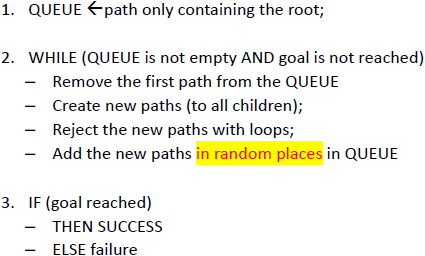

### Random numbers

Bij ***non deterministic search*** worden nieuwe paden op willekeurige plaatsen in de queue ingevoegd. We zullen dus ***willekeurige getallen*** of ***random numbers*** moeten genereren.

Gebruik hiervoor de functie `randint` van het package `random`. Zo geeft `randint(0, 5)` bijvoorbeeld een willekeurig getal (of random integer) terug uit de lijst `[0, 1, 2, 3, 4, 5]`. Let dus op dat de opgegeven grensen inclusief zijn! M.a.w. in ons voorbeeld kunnen 0 en 5 geselecteerd worden door `randint`!

Check de documentatie van `randint` voor meer uitleg: https://docs.python.org/3/library/random.html#random.randint


#### Oefening

Test de functie `randint` uit:
- importeer de functie `randint` uit de bibliotheek `random`
- selecteer een willekeurig getal tussen 0 en 10, grenzen inclusief
- print het getal.

#### Pseudo-random en seeds

De random functionaliteit in Python is, zoals in alle programmeertalen, gebaseerd op een algoritme dat een "pseudo-random" reeks getallen genereert. Dit zijn getallen die willekeurig of random lijken, en voor de meeste toepassingen ook als random mogen worden beschouwd. 

Maar in feite zijn deze getallen dus niet random! Daardoor kunnen we toch steeds dezelfde reeks van getallen genereren door het algoritme steeds op dezelfde manier te starten. Dat doen we door de "seed" op te geven. Deze algoritmen staan of vallen dus met de initialisatie van de seed, die het startpunt van de reeks "random" getallen bepaalt. M.a.w. bij een gelijke seed wordt steeds dezelfde reeks van "willekeurige" getallen gegenereerd.

Documentatie seed functie: https://docs.python.org/3/library/random.html#random.seed

In Python wordt voor de seed standaard de systeemtijd genomen, tenzij een betere bron beschikbaar is. De bron van de seed zal vooral in cryptografische toepassingen heel belangrijk zijn. Maar ook voor het debuggen van stochastische algoritmen is het toepassen van een seed zeer nuttig! Stochastische algoritmen bevatten elementen van "randomness" en maken dus ook gebruik van random number generators. Veel machine learning algoritmen behoren tot die categorie. 

### Invoegen in de queue

Nu we de `randint` functie kennen, kunnen we eenvoudig een willekeurige index genereren. Die index geeft dan de willekeurige positie aan waar we een nieuw item in een list gaan toevoegen. Daarvoor gebruiken we de methode `insert`.

`lst.insert(3, 6)` voegt bijvoorbeeld getal `6` in op positie met index `3` in list `lst`. Dat is dus de vierde positie!

Documentatie van `insert`: https://docs.python.org/3/library/stdtypes.html?highlight=list#mutable-sequence-types

#### Oefening

Test de `insert` methode uit (gebruik enkel `insert` om de lijst te wijzigen in deze oefening):
- initialiseer een lijst `[1, 2, 3, 4, 5, 6]`
- voeg `-1` toe op positie 4
- voeg `0` toe vooraan in de lijst
- voeg `10` toe achteraan de lijst
- voeg `99` toe op een willekeurige plaats in de lijst (alle posities zijn geldig, inclusief de eerste en laatste positie)

Print tussen alle stappen de lijst uit om de veranderingen weer te geven.

### Opdracht 1: Implementeer non deterministic search

We herhalen de pseudocode van NDS uit de cursus:

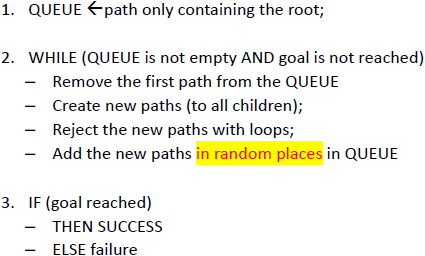

Implementeer nu de functie `nds(initial_path)`. Gebruik de functie `dfs_bfs` als voorbeeld.

#### Uittesten van `nds`

We testen nu de geïmplementeerde functie `nds` uit.

We kunnen dit vergelijken met dfs ...

... en bfs

Bij NDS krijgen we uiteraard niet altijd hetzelfde resultaat, maar normaal gezien ligt het resultaat van NDS ergens tussen DFS en BFS, zowel in uitvoeringstijd als maximum lengte van de queue. De verschillen zijn hier echter niet zo uitgesproken doordat ons probleem heel simpel is.

## Iterative deepening search

De pseudocode van IDS uit de cursus:

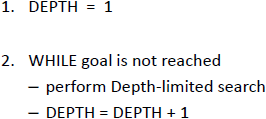

### Opdracht 2: Implementeer Depth-limited search

Voor de implementatie van IDS moeten we Depth-limited search implementeren.

De pseucode van Depth-limited search uit de cursus:

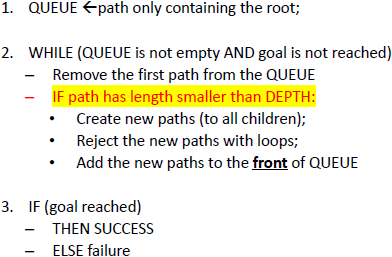

Implementeer `depth_limited_dfs(initial_path, limit)`.  Gebruik de functie `dfs_bfs` als voorbeeld, waarbij je DFS gebruikt omdat we hier de nieuwe paden vooraan de queue moeten toevoegen.

#### Uittesten van `depth_limited_dfs`

We testen nu de geïmplementeerde functie `depth_limited_dfs` uit.

Als we de limiet lager zetten vinden we geen oplossing.

### Opdracht 3: Implementeer Iterative deepening search

We herhalen de pseudocode van IDS uit de cursus:

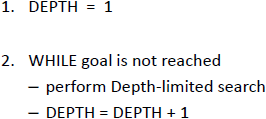

Implementeer `ids(initial_path)` door gebruik te maken van `depth_limited_dfs`.

Tip: functie `depth_limited_dfs` retourneert `None` als het geen pad naar het einddoel heeft gevonden, en anders geeft het het gevonden pad naar het doel terug. Checken of een variabele al dan niet `None` is, kan je met `is None` of `is not None` doen.

#### Uittesten van `ids`

We testen nu de geïmplementeerde functie `ids` uit.

Vergelijk dit met dfs ...

... en bfs

Je ziet dat de maximum lengte van de queue even groot is als DFS. De uitvoeringstijd ligt een beetje lager dan BFS.

Soms zijn de verschillen niet zo uitgesproken doordat ons probleem zo simpel is.

## Opdracht 4

Pas alle 4 de algoritmes toe op het doolhof uit de figuur aan het begin van de notebook. Vergelijk de lengte van de queue, de uitvoeringssnelheid en de lengte van het pad. Geef een `seed` op bij NDS zodat je steeds hetzelfde pad krijgt.

In [ ]:
maze2 = Maze.create(['....#...o',
                     '.........',
                     '#........',
                     '.#...#...',
                     '..#......',
                     '.........',
                     '.........',
                     '......#..',
                     '*......#.'])
maze2.plot()

### DFS

In [ ]:
dfs_path_to_goal = dfs_bfs(initial_path2, 'dfs')
MazePathPlotter(dfs_path_to_goal).plot()

### BFS

In [ ]:
bfs_path_to_goal = dfs_bfs(initial_path2, 'bfs')
MazePathPlotter(bfs_path_to_goal).plot()

### NDS

### IDS